In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp



In [2]:
model = tf.keras.models.load_model('../models/FFNN_fs8.h5')
# model = tf.keras.models.load_model('FFNN_fs8.h5')

In [3]:
file = '../data/fs8Diagram.txt'
data = pd.read_csv(file, names=['z', '$f\sigma_8$', 'err', '$\Omega_ref$'], sep = "\t", skiprows=3)
data = data[['z', '$f\sigma_8$', 'err']]
z = data.values[:,0]
y = data.values[:,1:]
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))
zor = scalerz.inverse_transform(z.reshape(-1,1))



In [4]:
ranz = np.linspace(0, 2, 1000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))

In [5]:
# plt.figure(figsize=(10, 7), dpi=100)
# plt.errorbar(z, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, pred_random[:,0], pred_random[:,1], markersize=2, fmt='o', 
#              ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m')
# plt.xlabel("Redshift z")

# plt.ylabel("$H(z)$")
# plt.xlim(0, 2)

In [6]:
from functools import partial
# Cosmological constants
Om = 0.342
# variance network
s8 = 0.8
h = 1
# def Ezlcdm(a):
#     return np.sqrt(Om*(1/a)**3 + 1 - Om)

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
# #     return Om*(1/a)**3 + 1 - Om
#     w0 = -1.0
#     wa = 0.0
#     rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
#     return (Om/a**3+(1.0-Om)*rhow)

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return h**2*(Om/a**3+(1.0-Om)*rhow)

  
# def growth_lcdm(z):
#     # Equation 7.77 from Doddie
#     af = 1./(1. + z)
#     r = intg.quad(GrowthIntegrand_a_lcdm, 1e-7, af)
#     gr = np.sqrt(RHSquared_a_lcdm(af))*r[0]  # assume precision is ok
#     gr *= 5/2.*Om
#     return gr
    

def growth_owacdm(z, w0, wa):
    # Equation 7.77 from Doddie
    af = 1./(1. + z)
    r = intg.quad(GrowthIntegrand_a_owacdm, 1e-7, af, args=(w0, wa))
    gr = np.sqrt(RHSquared_a_owacdm(af, w0, wa))*r[0]  # assume precision is ok
    gr *= 5/2.*Om
    return gr

# # returns the growth factor as a function of redshift
# def GrowthIntegrand_a_lcdm(a):
#     rhsquareda = RHSquared_a_lcdm(a) 
#     return 1./(rhsquareda*a*a)**(1.5)

def GrowthIntegrand_a_owacdm(a, w0, wa):
    rhsquareda = RHSquared_a_owacdm(a, w0=w0, wa=wa) 
    return 1./(rhsquareda*a*a)**(1.5)

# def fs8lcdm(z):
#     return -s8*(1+z)*derivative(growth_lcdm, z, dx=1e-6)/growth_lcdm(0)

def fs8owacdm(z, w0=-1, wa=0):
    return -s8*(1+z)*derivative(growth_owacdm, z, dx=1e-6, args=(w0, wa))/growth_owacdm(0, w0, wa)

In [7]:
z = np.linspace(0.0, 2, 100)
flcdm = []
fowacdm1 = []
fowacdm2 = []
fowacdm3 = []
fowacdm4 = []

# flcdm = []
for zz in z:
#     flcdm.append(fs8lcdm(zz))
    flcdm.append(fs8owacdm(zz, w0=-1, wa=0.0))
    fowacdm1.append(fs8owacdm(zz, w0=-1, wa=0.5))
    fowacdm2.append(fs8owacdm(zz, w0=-1, wa=-0.5))
    fowacdm3.append(fs8owacdm(zz, w0=-0.8, wa=-0.4))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
fowacdm2 = np.array(fowacdm2)
fowacdm3 = np.array(fowacdm3)


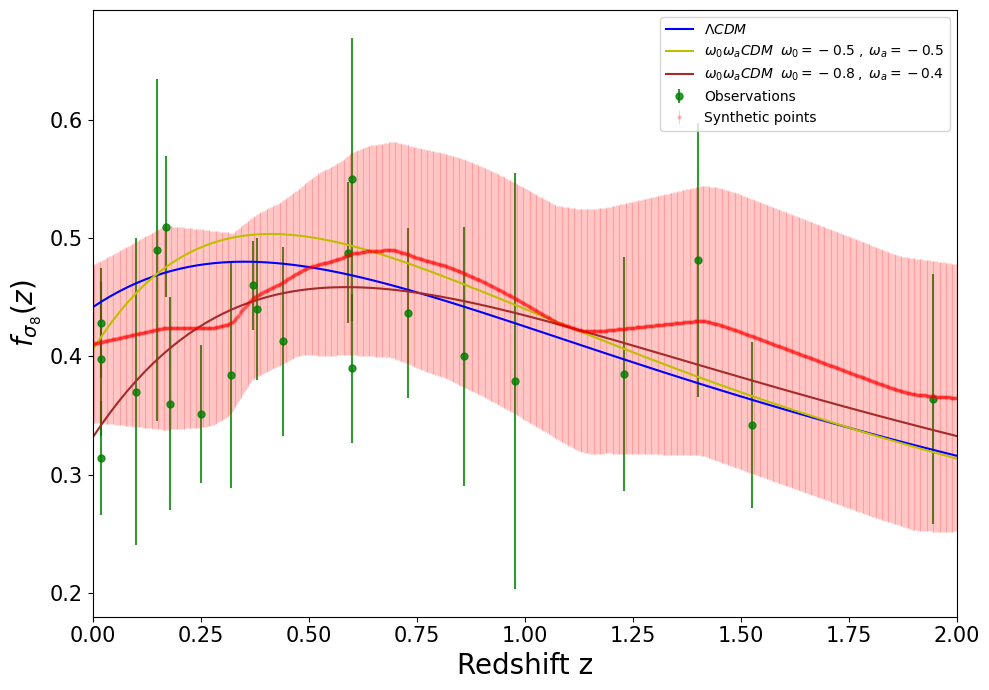

In [8]:
z = np.linspace(0, 2, 100)
plt.figure(figsize=(10, 7), dpi=100)

plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations', alpha=0.8)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], label='Synthetic points', 
             markersize=2, fmt='o', 
             ecolor='red', capthick=2, elinewidth=0.8, alpha=0.2, c='r',)

plt.plot(z, flcdm, label='$\Lambda CDM$', c='b')
# plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_0 = -1 \;,\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_0 =-0.5 \;,\; \omega_a=-0.5$', c='y')
plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_0 = -0.8 \;,\; \omega_a=-0.4$', c='brown')
# plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_a=0$', c='brown')
plt.xlim(0, 2)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("$f_{\sigma_8}(z)$", fontsize=20)
plt.tight_layout()
plt.legend()

# plt.savefig("Syntheticfs8b.png",dpi=100)

In [9]:
fs8chain = np.loadtxt('annfs850_.dat')

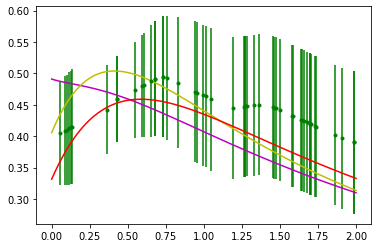

In [10]:
plt.errorbar(fs8chain[:,0], fs8chain[:,1], yerr=fs8chain[:,2],  fmt='g.')
plt.plot(z, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_0 = -1 \;,\; \omega_a=0.5$', c='m')
plt.plot(z, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_0 =-1 \;,\; \omega_a=-0.5$', c='y')
plt.plot(z, fowacdm3, label='$\omega_0\omega_aCDM \;\; \omega_0 = -0.7 \;,\; \omega_a=-0.3$', c='r')